In [17]:
%load_ext autoreload
%autoreload 2
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
df_raw = load_dataframe()

In [19]:
df_raw.head()

,text,label
0,US trade gap ballooned in October\n\nThe US tr...,business
1,Japanese mogul arrested for fraud\n\nOne of Ja...,business
2,Jarvis sells Tube stake to Spain\n\nShares in ...,business
3,Small firms 'hit by rising costs'\n\nRising fu...,business
4,Oil prices fall back from highs\n\nOil prices ...,business


In [20]:
PREPROCESSING_PIPELINE = [
                        lower,
                        remove_emails,
                        replace_special_characters,
                        replace_br,
                        filter_out_uncommon_symbols,
                        remove_stopwords,
                        strip_text
                    ]

In [21]:
print('Pre-processing text...')
 
print()
print(f'[Debug] Before:\n{df_raw.text.values[0]}')
print()
 
# Replace each sentence with its pre-processed version
df = df_raw.copy()
df['text'] = df_raw['text'].apply(lambda txt: text_prepare(txt, PREPROCESSING_PIPELINE))

print(f'[Debug] After:\n{df.text.values[0]}')
print()
 
print("Pre-processing completed!")

Pre-processing text...

[Debug] Before:
US trade gap ballooned in October

The US trade deficit widened by more than expected in October, hitting record levels after higher oil prices raised import costs, figures have shown

The trade shortfall was $55.5bn (£29bn), up 9% from September, the Commerce Department said. That pushed the 10 month deficit to $500.5bn. Imports rose by 3.4%, while exports increased by only 0.6%. A weaker dollar also increased the cost of imports, though this should help drive export demand in coming months. "Things are getting worse, but that's to be expected," said David Wyss of Standard & Poor's in New York. "The first thing is that when the dollar goes down, it increases the price of imports. "We are seeing improved export orders. Things seem to be going in the right direction."

Despite this optimism, significant concerns remain as to how the US will fund its trade and budget deficits should they continue to widen. Another problem highlighted by analysts wa

[Debug] After:
us trade gap ballooned october us trade deficit widened expected october hitting record levels higher oil prices raised import costs figures shown trade shortfall 555bn 29bn 9 september commerce department said pushed 10 month deficit 5005bn imports rose 34 exports increased 06 weaker dollar also increased cost imports though help drive export demand coming months things getting worse thats expected said david wyss standard poors new york first thing dollar goes increases price imports seeing improved export orders things seem going right direction despite optimism significant concerns remain us fund trade budget deficits continue widen another problem highlighted analysts growing trade gap china accused keeping currency artificially weak order boost exports us imported almost 20bn worth goods china october exporting little 3bn seems key worry existed currency market still remains said anthony crescenzi bond strategist miller tabak new york trade deficit shortfall china 

In [22]:
# drop from df rows where text number of words are less than 50
df = df[df['text'].apply(lambda x: len(x.split()) > 100)]

In [23]:
path = 'vocab/'
if not os.path.exists(path):
    os.makedirs(path)

# Check if vocabulary has already been built
vocab_regex = re.compile(r'idx_to_word\.pkl|word_to_idx\.pkl|word_listing\.pkl')

if len(os.listdir(path)) > 0 and all([vocab_regex.search(f) for f in os.listdir(path)]):
    print('Loading existing vocabulary...')
    idx_to_word, word_to_idx, word_listing = load_vocab()
    print('Vocabulary loaded!')
else:
    print('Building vocabulary...')
    idx_to_word, word_to_idx, word_listing = build_vocabulary(df)
    print('Saving vocabulary...')
    save_vocab(idx_to_word, word_to_idx, word_listing)
    print('Vocabulary built!')

Loading existing vocabulary...
Vocabulary loaded!


In [24]:
evaluate_vocabulary(idx_to_word, word_to_idx, word_listing, df)

[Vocabulary Evaluation] Size checking...
[Vocabulary Evaluation] Content checking...


  0%|          | 0/31383 [00:00<?, ?it/s]

100%|██████████| 31383/31383 [00:00<00:00, 1080119.50it/s]


[Vocabulary Evaluation] Consistency checking...


100%|██████████| 783/783 [00:00<00:00, 19596.28it/s]


[Vocabulary Evaluation] Toy example checking...


100%|██████████| 2/2 [00:00<00:00, 19284.16it/s]


In [25]:
corpus_len = df['text'].apply(lambda x: len(x.split(' '))).values
max_nodes_in_graph = np.min(corpus_len)

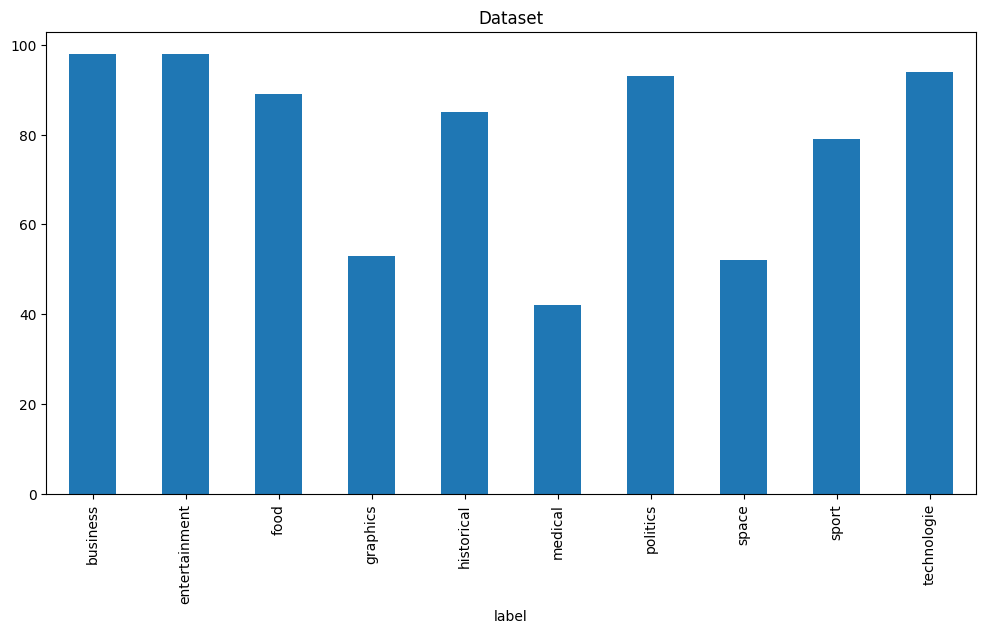

In [26]:
plot_label_distribution([df], labels=['Dataset'])

## PMI

In [27]:
text_tests = df['text'].values
PMIs = []
W2Is = []
I2Ws = []
for text in text_tests:
    PMI, WTI, ITW = compute_pmi(text)
    PMIs.append(PMI)
    W2Is.append(WTI)
    I2Ws.append(ITW)

In [28]:
PMIs_thr = []
for pmi in PMIs:
    threshold = compute_threshold(pmi)
    PMIs_thr.append(threshold_pmi(pmi, threshold))

In [29]:
centrality_measure = 'degree'
PMIs_centrality = [compute_centrality(pmi, centrality_measure) for pmi in PMIs_thr]
# sort by centrality
PMIs_centrality = [sorted(pmi.items(), key=lambda x: x[1], reverse=True) for pmi in PMIs_centrality]

# get top max_node_in_graph words
PMIs_centrality = [pmi[:max_nodes_in_graph] for pmi in PMIs_centrality]

In [30]:
import sklearn
from sklearn import cluster

# Construct a similarity matrix from the PMI matrices
similarity_matrix = np.zeros((len(PMIs), len(PMIs)))
for i in range(len(PMIs)):
  for j in range(len(PMIs)):
    pmi_to_check = [PMIs[i], PMIs[j]]
    pmi_centrality_to_check = [get_index_from_measure_matrix(PMIs_centrality[i]), get_index_from_measure_matrix(PMIs_centrality[j])]
    i2w_to_check = [I2Ws[i], I2Ws[j]]
    w2i_to_check = [W2Is[i], W2Is[j]]
    similarity_matrix[i, j] = compute_similarity_score(pmi_to_check, pmi_centrality_to_check, i2w_to_check, w2i_to_check)


# print(similarity_matrix)
# Choose a clustering algorithm
kmeans = sklearn.cluster.KMeans(n_clusters=10)

# Apply the clustering algorithm to the similarity matrix
cluster_labels = kmeans.fit_predict(similarity_matrix)

In [31]:
def assign_classes_to_clusters_with_highest_number_of_elements(kmeans_labels, ground_truth_labels):  
    cluster_to_class_counts = {}
    for i in range(len(kmeans_labels)):
        cluster_label = kmeans_labels[i]
        ground_truth_label = ground_truth_labels[i]
        if cluster_label not in cluster_to_class_counts:
            cluster_to_class_counts[cluster_label] = {}
        if ground_truth_label not in cluster_to_class_counts[cluster_label]:
            cluster_to_class_counts[cluster_label][ground_truth_label] = 0
        cluster_to_class_counts[cluster_label][ground_truth_label] += 1
    cluster_to_class_labels = {}
    for cluster_label in cluster_to_class_counts:
        max_count_class_label = max(cluster_to_class_counts[cluster_label].items(), key=lambda item: item[1])[0]
        cluster_to_class_labels[cluster_label] = max_count_class_label   
    return cluster_to_class_labels

In [32]:
kmeans_labels = cluster_labels
ground_truth_labels = df['label'].values
cluster_to_class_labels = assign_classes_to_clusters_with_highest_number_of_elements(kmeans_labels, ground_truth_labels)
accuracy = np.mean([cluster_to_class_labels[kmeans_labels[i]] == ground_truth_labels[i] for i in range(len(kmeans_labels))])
print('Accuracy:', accuracy)

Accuracy: 0.5772669220945083
